# Cross-Entropy Method

---

In this notebook, we will train the Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.

### 1. Import the Necessary Packages

In [1]:
!pip install gymnasium[classic-control]
import gymnasium as gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

  Using cached pygame-2.1.3.dev8-cp39-cp39-win_amd64.whl (10.6 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.0
    Uninstalling pygame-2.1.0:
      Successfully uninstalled pygame-2.1.0


### 2. Instantiate the Environment and Agent

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")

seed=101
np.random.seed(seed)
obs, info = env.reset(seed=seed)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
  - low: [-1.]
  - high: [1.]


In [3]:
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        self.tanh = torch.tanh
        
    def act(self, state):
        x = torch.from_numpy(state).to(device)
        return self.forward(x)

    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state, _ = self.env.reset(seed=seed)
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, trun, _ = self.env.step(action)
            done = done or trun
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return


In [4]:
    agent = Agent(env).to(device)

### 3. Train the Agent with the Cross-Entropy Method

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [5]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores


In [6]:
scores = cem()

Episode 10	Average Score: -3.30
Episode 20	Average Score: -5.74
Episode 30	Average Score: -4.71
Episode 40	Average Score: -3.89
Episode 50	Average Score: -3.18
Episode 60	Average Score: -2.80
Episode 70	Average Score: -2.79
Episode 80	Average Score: -2.64
Episode 90	Average Score: -2.38
Episode 100	Average Score: -2.16
Episode 110	Average Score: -1.85
Episode 120	Average Score: -1.06
Episode 130	Average Score: -0.83
Episode 140	Average Score: -0.73
Episode 150	Average Score: -0.71
Episode 160	Average Score: -0.63
Episode 170	Average Score: -0.38
Episode 180	Average Score: -0.23
Episode 190	Average Score: -0.27
Episode 200	Average Score: -0.30
Episode 210	Average Score: 8.99
Episode 220	Average Score: 18.51
Episode 230	Average Score: 28.04
Episode 240	Average Score: 37.59
Episode 250	Average Score: 47.07
Episode 260	Average Score: 56.56
Episode 270	Average Score: 66.07
Episode 280	Average Score: 75.49
Episode 290	Average Score: 85.16

Environment solved in 195 iterations!	Average Score:

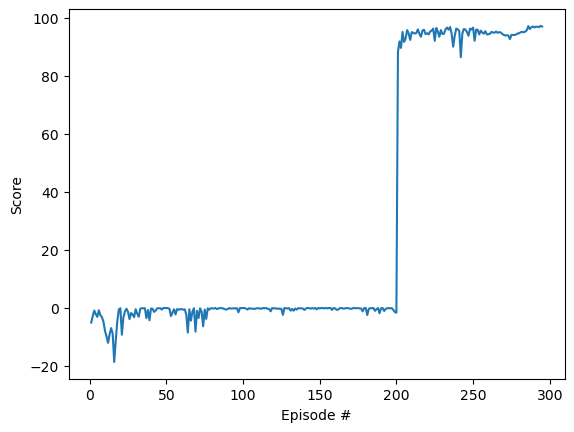

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [8]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint_OG.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_OG.pth'

In [ ]:
frames = []
n_steps = 300
n_eps = 3

for i in range(n_eps):
    state, info = env.reset(seed=seed)
    frames.append(env.render()) 
    for j in range(n_steps):
        action = agent.act(state)
        state, reward, done, trun, info = env.step(action)
        frames.append(env.render())
        if done or trun:
            break 

frames = np.asarray(frames)
print(frames.shape)

In [ ]:
# Display recorded episode

img = plt.imshow(frames[0])
for f in frames[1:]:
    img.set_data(f) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [ ]:
#env.close()
